# 05 - Content-Based Filtering

Content-based filtering recommends movies based on **what a movie is**, not who liked it.
It builds a profile of each movie's content (genres, tags, year) and finds similar movies.

This notebook:
- Builds TF-IDF feature vectors from user tags
- Combines with genre and metadata features
- Computes movie-to-movie similarity
- Builds user profiles from their rating history
- Generates and evaluates content-based recommendations

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import pickle
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix, hstack

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Configuration and Data

In [17]:
project_root = Path.cwd().parent
config_path = project_root / 'config' / 'config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

processed_dir = project_root / config['data']['processed_dir']
features_dir  = project_root / config['data']['features_dir']
models_dir    = project_root / config['models']['save_dir']
models_dir.mkdir(parents=True, exist_ok=True)

eval_config = config['evaluation']

print(f"Processed dir : {processed_dir}")
print(f"Features dir  : {features_dir}")
print(f"Models dir    : {models_dir}")

Processed dir : c:\Users\ololi\StudioProjects\movie-recommender\src\data\processed
Features dir  : c:\Users\ololi\StudioProjects\movie-recommender\src\data\features
Models dir    : c:\Users\ololi\StudioProjects\movie-recommender\src\models


In [18]:
print("Loading data...")

movies  = pd.read_parquet(features_dir  / 'movie_features.parquet')
ratings = pd.read_parquet(processed_dir / 'ratings_cleaned.parquet')
tags    = pd.read_parquet(processed_dir / 'tags_cleaned.parquet')

with open(features_dir / 'id_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)

movie_id_map = mappings['movie_id_map']
user_id_map  = mappings['user_id_map']
idx_to_movie = mappings['idx_to_movie']
idx_to_user  = mappings['idx_to_user']

print(f"  Movies  : {len(movies):,}")
print(f"  Ratings : {len(ratings):,}")
print(f"  Tags    : {len(tags):,}")
print(f"  Tag unique values: {tags['tag'].nunique():,}")

Loading data...
  Movies  : 32,424
  Ratings : 24,914,810
  Tags    : 1,034,097
  Tag unique values: 68,634


## 2. Build Movie Feature Vectors

We combine three sources of information into a single feature vector per movie:
- **Genres** - multi-hot encoded (already in movie_features)
- **Tags** - TF-IDF on user-supplied text tags
- **Year** - normalised release year

### 2.1 Genre Features

In [19]:
print("Extracting genre features...")

# Columns that start with 'genre_' were created in notebook 03
genre_cols = [c for c in movies.columns if c.startswith('genre_')]
genre_features = movies[genre_cols].values.astype(np.float32)

print(f"  Genre feature matrix: {genre_features.shape}")
print(f"  Genres: {[c.replace('genre_', '') for c in genre_cols]}")

Extracting genre features...
  Genre feature matrix: (32424, 20)
  Genres: ['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


### 2.2 TF-IDF Tag Features

**TF-IDF** (Term Frequency - Inverse Document Frequency) converts text into numbers.
- **TF**: how often a tag appears for this movie
- **IDF**: penalises tags that appear for almost every movie (e.g. 'good') so rare, specific tags get higher weight

A movie tagged 'neo-noir' gets a high score for that term because few movies have it.

In [20]:
print("Building TF-IDF tag features...")

# Aggregate all tags for each movie into one string
# dropna() removes any null tag values before joining
movie_tags = (
    tags.groupby('movieId')['tag']
    .apply(lambda x: ' '.join(x.dropna().str.lower().str.strip()))
    .reset_index()
    .rename(columns={'tag': 'tag_string'})
)

# Merge with movies (movies with no tags get an empty string)
movies = movies.merge(movie_tags, on='movieId', how='left')
movies['tag_string'] = movies['tag_string'].fillna('')

print(f"  Movies with tags: {(movies['tag_string'] != '').sum():,} / {len(movies):,}")

# TF-IDF vectoriser
tfidf = TfidfVectorizer(
    max_features=config['models']['content_based']['max_features'],
    min_df=config['models']['content_based']['min_keyword_freq'],
    ngram_range=(1, 2),   # single words and bigrams (e.g. 'based on book')
    sublinear_tf=True     # use log(TF) to dampen the effect of very frequent tags
)

tag_features = tfidf.fit_transform(movies['tag_string'])

print(f"  TF-IDF matrix shape: {tag_features.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"\n  Top 20 tags by IDF (most distinctive):")
idf_scores = pd.Series(tfidf.idf_, index=tfidf.get_feature_names_out())
print(f"  {list(idf_scores.nlargest(20).index)}")

Building TF-IDF tag features...
  Movies with tags: 28,569 / 32,424
  TF-IDF matrix shape: (32424, 1000)
  Vocabulary size: 1,000

  Top 20 tags by IDF (most distinctive):
  ['christopher nolan', 'wes anderson', 'hayao', 'hayao miyazaki', 'nolan', 'quentin tarantino', 'stanley kubrick', 'miyazaki', 'powerful ending', 'gosling', 'ryan gosling', 'ghibli', 'studio ghibli', 'kubrick', 'quentin', 'tarantino', 'coen brothers', 'excellent script', 'provoking twist', 'coen']


### 2.3 Year Feature

In [21]:
print("Building year feature...")

# Normalise year to [0, 1] so it doesn't dominate the other features
scaler = MinMaxScaler()
year_filled = movies['year'].fillna(movies['year'].median()).values.reshape(-1, 1)
year_feature = scaler.fit_transform(year_filled).astype(np.float32)

print(f"  Year range: {year_filled.min():.0f} – {year_filled.max():.0f}")
print(f"  Year feature shape: {year_feature.shape}")

Building year feature...
  Year range: 1874 – 2019
  Year feature shape: (32424, 1)


### 2.4 Combine All Features

In [22]:
print("Combining all features...")

# Weights: give genres more importance than tags, year least
GENRE_WEIGHT = 2.0
TAG_WEIGHT   = 1.0
YEAR_WEIGHT  = 0.5

from scipy.sparse import csr_matrix

genre_sparse = csr_matrix(genre_features * GENRE_WEIGHT)
tag_sparse   = tag_features * TAG_WEIGHT
year_sparse  = csr_matrix(year_feature  * YEAR_WEIGHT)

# Stack horizontally: each row = one movie, columns = all features
movie_feature_matrix = hstack([genre_sparse, tag_sparse, year_sparse], format='csr')

print(f"  Combined feature matrix: {movie_feature_matrix.shape}")
print(f"    Genre dims  : {genre_sparse.shape[1]}  (weight {GENRE_WEIGHT}x)")
print(f"    Tag dims    : {tag_sparse.shape[1]}  (weight {TAG_WEIGHT}x)")
print(f"    Year dims   : {year_sparse.shape[1]}  (weight {YEAR_WEIGHT}x)")

Combining all features...
  Combined feature matrix: (32424, 1021)
    Genre dims  : 20  (weight 2.0x)
    Tag dims    : 1000  (weight 1.0x)
    Year dims   : 1  (weight 0.5x)


## 3. Movie-to-Movie Similarity

**Cosine similarity** measures the angle between two feature vectors.
- Score of 1.0 = identical content profile
- Score of 0.0 = nothing in common

We don't compute a full similarity matrix (32K × 32K = 8 billion values).
Instead we look up similar movies on demand.

In [23]:
# Build a lookup: movieId → row index in movie_feature_matrix
movie_idx_lookup = {movie_id: idx for idx, movie_id in enumerate(movies['movieId'])}
idx_to_movie_id  = {idx: movie_id for movie_id, idx in movie_idx_lookup.items()}


def get_similar_movies(movie_id, n=10, verbose=True):
    """Return the n most content-similar movies to a given movie."""
    if movie_id not in movie_idx_lookup:
        print(f"Movie {movie_id} not found.")
        return pd.DataFrame()

    idx = movie_idx_lookup[movie_id]
    movie_vec = movie_feature_matrix[idx]       # (1, n_features)

    # Compute cosine similarity between this movie and all others
    sim_scores = linear_kernel(movie_vec, movie_feature_matrix).flatten()

    # Sort descending, skip index 0 (the movie itself)
    top_indices = np.argsort(sim_scores)[::-1][1:n+1]

    results = []
    for i in top_indices:
        sim_movie_id = idx_to_movie_id[i]
        row = movies[movies['movieId'] == sim_movie_id].iloc[0]
        results.append({
            'movieId'   : sim_movie_id,
            'title'     : row['title'],
            'genres'    : row['genres'],
            'year'      : row.get('year', ''),
            'similarity': round(sim_scores[i], 4)
        })

    df = pd.DataFrame(results)
    if verbose:
        source = movies[movies['movieId'] == movie_id].iloc[0]
        print(f"Movies similar to: '{source['title']}' ({source['genres']})")
        print(df.to_string(index=False))
    return df


print("Similarity function defined.")

Similarity function defined.


In [24]:
# Test on some well-known movies
test_movies = [
    1,      # Toy Story
    296,    # Pulp Fiction
    527,    # Schindler's List
]

for movie_id in test_movies:
    print(f"\n{'='*65}")
    get_similar_movies(movie_id, n=8)
print()


Movies similar to: 'Toy Story (1995)' (Adventure|Animation|Children|Comedy|Fantasy)
 movieId                             title                                              genres   year  similarity
    3114                Toy Story 2 (1999)         Adventure|Animation|Children|Comedy|Fantasy 1999.0     20.9174
    4886             Monsters, Inc. (2001)         Adventure|Animation|Children|Comedy|Fantasy 2001.0     20.7224
   78499                Toy Story 3 (2010)    Adventure|Animation|Children|Comedy|Fantasy|IMAX 2010.0     20.7151
    4306                      Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance 2001.0     20.6158
    2294                       Antz (1998)         Adventure|Animation|Children|Comedy|Fantasy 1998.0     20.5427
  136016          The Good Dinosaur (2015)         Adventure|Animation|Children|Comedy|Fantasy 2015.0     20.5382
  115879 Toy Story Toons: Small Fry (2011)         Adventure|Animation|Children|Comedy|Fantasy 2011.0     20.5201
   

## 4. Build User Profiles

A user profile is the **weighted average of the feature vectors of all movies they've liked**.

If a user gave a movie 5 stars, that movie's features contribute a lot.
If they gave 2 stars, it contributes very little (or negatively).

The result is a vector that represents the user's taste in content.

In [25]:
print("Building user profiles...")

# Use only ratings above the midpoint so profiles skew positive
RATING_MIDPOINT = 3.0

def build_user_profile(user_id, ratings_df):
    """Build a content feature vector representing this user's taste."""
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    if len(user_ratings) == 0:
        return None

    profile = np.zeros(movie_feature_matrix.shape[1])
    total_weight = 0.0

    for _, row in user_ratings.iterrows():
        if row['movieId'] not in movie_idx_lookup:
            continue
        idx    = movie_idx_lookup[row['movieId']]
        weight = row['rating'] - RATING_MIDPOINT   # positive for liked, negative for disliked
        profile += weight * movie_feature_matrix[idx].toarray().flatten()
        total_weight += abs(weight)

    if total_weight == 0:
        return None

    return profile / total_weight   # normalise


# Pre-build profiles for a sample of users to test speed
sample_users = ratings['userId'].value_counts().head(500).index.tolist()

start = time.time()
sample_profiles = {}
for uid in sample_users:
    p = build_user_profile(uid, ratings)
    if p is not None:
        sample_profiles[uid] = p

elapsed = time.time() - start
print(f"  Built {len(sample_profiles)} profiles in {elapsed:.1f}s")
print(f"  Profile vector size: {list(sample_profiles.values())[0].shape[0]}")

Building user profiles...
  Built 500 profiles in 61.9s
  Profile vector size: 1021


## 5. Generate Content-Based Recommendations

In [26]:
def get_cb_recommendations(user_id, ratings_df, n=10, verbose=True):
    """Recommend movies based on the user's content profile."""
    profile = build_user_profile(user_id, ratings_df)
    if profile is None:
        print(f"No profile for user {user_id}.")
        return pd.DataFrame()

    # Movies the user has already rated
    rated_ids = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])

    # Cosine similarity between user profile and all movies
    profile_vec = profile.reshape(1, -1)
    sim_scores  = linear_kernel(profile_vec, movie_feature_matrix).flatten()

    # Sort and filter already-rated movies
    sorted_indices = np.argsort(sim_scores)[::-1]
    results = []
    for idx in sorted_indices:
        movie_id = idx_to_movie_id[idx]
        if movie_id in rated_ids:
            continue
        row = movies[movies['movieId'] == movie_id].iloc[0]
        results.append({
            'movieId'   : movie_id,
            'title'     : row['title'],
            'genres'    : row['genres'],
            'year'      : row.get('year', ''),
            'cb_score'  : round(sim_scores[idx], 4),
            'avg_rating': round(row.get('avg_rating', 0), 2),
            'num_ratings': int(row.get('num_ratings', 0))
        })
        if len(results) == n:
            break

    df = pd.DataFrame(results)

    if verbose:
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        top_rated = (
            user_ratings.nlargest(5, 'rating')
            .merge(movies[['movieId', 'title', 'genres']], on='movieId')
        )
        print(f"\n{'='*65}")
        print(f"User {user_id}  |  {len(user_ratings):,} ratings  |  avg {user_ratings['rating'].mean():.2f}")
        print(f"{'='*65}")
        print("Top rated:")
        for _, r in top_rated.iterrows():
            print(f"  {r['rating']:.1f} – {r['title']} ({r['genres']})")
        print(f"\nContent-based recommendations:")
        for _, r in df.iterrows():
            print(f"  {r['cb_score']:.4f}  {r['title']} ({r['genres']})")

    return df


print("CB recommendation function defined.")

CB recommendation function defined.


In [27]:
# Generate recommendations for 3 sample users
top_n = config['recommendations']['default_top_n']
demo_users = ratings['userId'].value_counts().head(3).index.tolist()

for uid in demo_users:
    get_cb_recommendations(uid, ratings, n=top_n)


User 72315  |  22,213 ratings  |  avg 3.14
Top rated:
  5.0 – Hate (Haine, La) (1995) (Crime|Drama)
  5.0 – From the Journals of Jean Seberg (1995) (Documentary)
  5.0 – Before Sunrise (1995) (Drama|Romance)
  5.0 – Three Colors: Red (Trois couleurs: Rouge) (1994) (Drama)
  5.0 – Three Colors: Blue (Trois couleurs: Bleu) (1993) (Drama)

Content-based recommendations:
  1.4990  Wanderlust (2006) (Comedy|Documentary|Drama|Romance)
  1.3708  Song of the Thin Man (1947) (Comedy|Crime|Drama|Musical|Mystery|Romance)
  1.3565  Revolutionary Girl Utena: Adolescence of Utena (a.k.a. Revolutionary Girl Utena the Movie) (Shoujo kakumei Utena: Adolescence mokushiroku) (1999) (Action|Adventure|Animation|Comedy|Drama|Fantasy|Romance)
  1.3500  With Fire and Sword (Ogniem i mieczem) (1999) (Adventure|Crime|Drama|Romance|War)
  1.3480  Happy New Year (2014) (Action|Comedy|Crime|Drama|Musical|Romance)
  1.3326  Stephen Tobolowsky's Birthday Party (2005) (Comedy|Documentary|Drama)
  1.3303  The Three S

## 6. Evaluate Content-Based Model

We evaluate using the same temporal train/test split as notebook 04.

In [28]:
print("Creating train/test split (same as CF notebook)...")

ratings_sorted = ratings.sort_values('timestamp')
split_idx = int(len(ratings_sorted) * (1 - eval_config['test_size']))
train_df  = ratings_sorted.iloc[:split_idx].copy()
test_df   = ratings_sorted.iloc[split_idx:].copy()

# Only keep test ratings for movies that exist in our feature matrix
known_movies = set(movie_idx_lookup.keys())
test_df = test_df[test_df['movieId'].isin(known_movies)]

print(f"  Train : {len(train_df):,} ratings")
print(f"  Test  : {len(test_df):,} ratings  (after filtering unknown movies)")

Creating train/test split (same as CF notebook)...
  Train : 19,931,848 ratings
  Test  : 4,982,962 ratings  (after filtering unknown movies)


In [29]:
print("Building user profiles from training data...")
print("(This may take a few minutes for 100K+ users)")

start = time.time()

# Get users that appear in both train and test
test_user_ids = test_df['userId'].unique()
train_user_ids = set(train_df['userId'].unique())
eval_user_ids  = [u for u in test_user_ids if u in train_user_ids]

print(f"  Users to profile: {len(eval_user_ids):,}")

user_profiles = {}
for i, uid in enumerate(eval_user_ids):
    p = build_user_profile(uid, train_df)
    if p is not None:
        user_profiles[uid] = p
    if (i + 1) % 10000 == 0:
        print(f"  Progress: {i+1:,}/{len(eval_user_ids):,}")

elapsed = time.time() - start
print(f"  Built {len(user_profiles):,} profiles in {elapsed:.1f}s ({elapsed/60:.1f} min)")

Building user profiles from training data...
(This may take a few minutes for 100K+ users)
  Users to profile: 6,388
  Built 6,388 profiles in 172.7s (2.9 min)


In [30]:
print("Generating predictions on test set...")
print("(Sampling 100K test ratings for speed)")

# Sample test ratings where user has a profile
test_with_profile = test_df[test_df['userId'].isin(user_profiles)]
sample_size = min(100_000, len(test_with_profile))
test_sample = test_with_profile.sample(n=sample_size, random_state=eval_config['random_state'])

start = time.time()

true_ratings = []
pred_scores  = []

for i, (_, row) in enumerate(test_sample.iterrows()):
    uid      = row['userId']
    movie_id = row['movieId']
    profile  = user_profiles[uid]

    idx        = movie_idx_lookup[movie_id]
    movie_vec  = movie_feature_matrix[idx].toarray().flatten()
    sim        = np.dot(profile, movie_vec) / (
                     np.linalg.norm(profile) * np.linalg.norm(movie_vec) + 1e-9)

    true_ratings.append(row['rating'])
    pred_scores.append(sim)

    if (i + 1) % 20000 == 0:
        print(f"  Progress: {i+1:,}/{sample_size:,}")

elapsed = time.time() - start
print(f"  Done in {elapsed:.1f}s")

true_ratings = np.array(true_ratings)
pred_scores  = np.array(pred_scores)

print(f"\n  CB similarity score range: {pred_scores.min():.4f} – {pred_scores.max():.4f}")

Generating predictions on test set...
(Sampling 100K test ratings for speed)
  Progress: 20,000/100,000
  Progress: 40,000/100,000
  Progress: 60,000/100,000
  Progress: 80,000/100,000
  Progress: 100,000/100,000
  Done in 4.6s

  CB similarity score range: -0.9102 – 0.9468


In [37]:
# Scale CB similarity score [0,1] to rating scale [0.5, 5.0] for RMSE comparison
# Simple linear mapping: score → rating
min_score, max_score = pred_scores.min(), pred_scores.max()
pred_ratings_scaled = 0.5 + 4.5 * (pred_scores - min_score) / (max_score - min_score + 1e-9)

rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings_scaled))
mae  = mean_absolute_error(true_ratings, pred_ratings_scaled)

print("\n" + "="*50)
print("Content-Based Filtering Results")
print("="*50)
print(f"  RMSE : {rmse:.4f}")
print(f"  MAE  : {mae:.4f}")

cb_results = {'model': 'Content-Based', 'rmse': rmse, 'mae': mae}


Content-Based Filtering Results
  RMSE : 1.1027
  MAE  : 0.8604


## 7. Visualise Feature Space

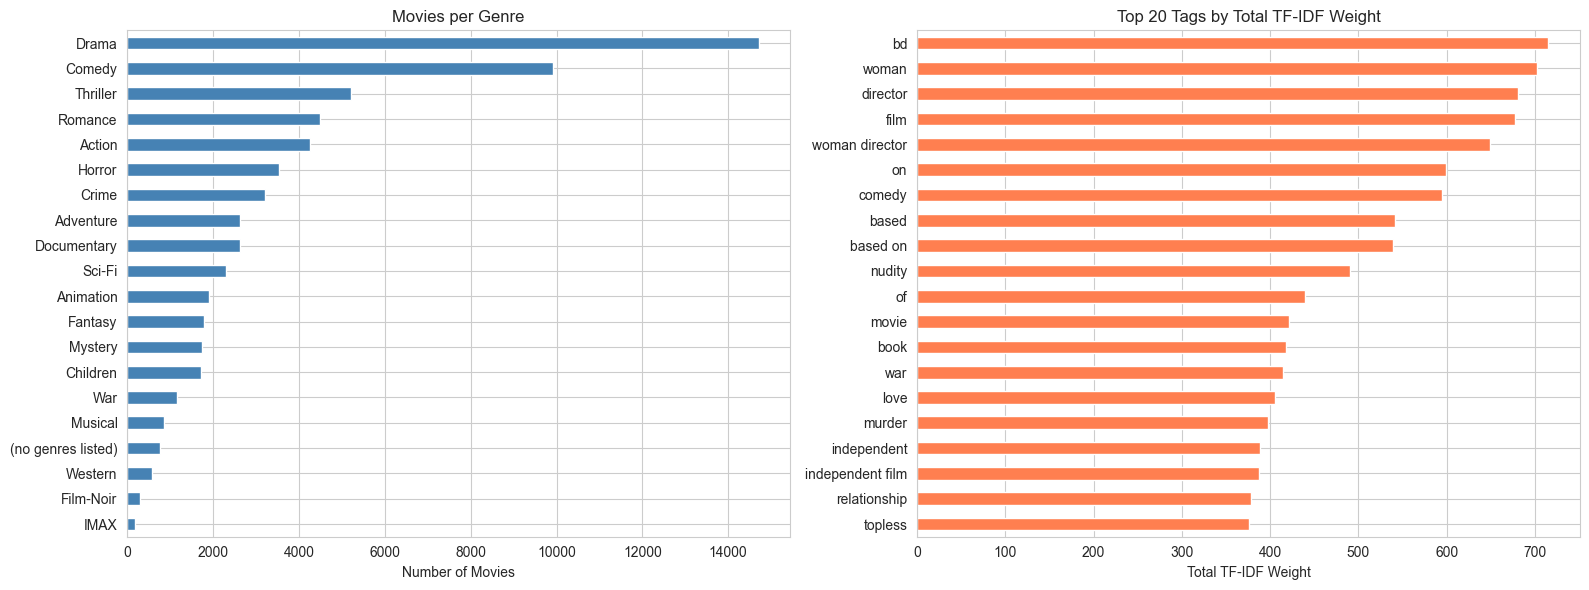

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Genre distribution among all movies ---
genre_sums = pd.Series(
    genre_features.sum(axis=0),
    index=[c.replace('genre_', '') for c in genre_cols]
).sort_values(ascending=False)

genre_sums.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Movies per Genre')
axes[0].set_xlabel('Number of Movies')
axes[0].invert_yaxis()

# --- Top TF-IDF tags by total weight across all movies ---
tag_totals = np.array(tag_features.sum(axis=0)).flatten()
top_tag_idx = np.argsort(tag_totals)[::-1][:20]
top_tags = pd.Series(
    tag_totals[top_tag_idx],
    index=tfidf.get_feature_names_out()[top_tag_idx]
)

top_tags.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 20 Tags by Total TF-IDF Weight')
axes[1].set_xlabel('Total TF-IDF Weight')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

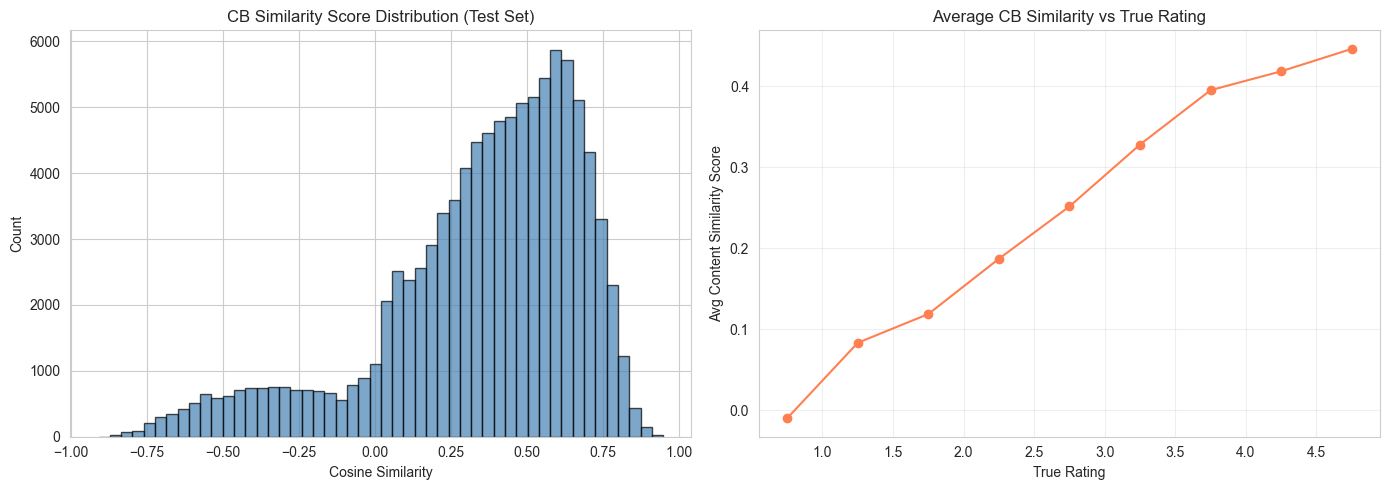

In [33]:
# Similarity score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(pred_scores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('CB Similarity Score Distribution (Test Set)')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Count')

# Similarity vs true rating
bins = np.linspace(true_ratings.min(), true_ratings.max(), 10)
bin_labels = np.digitize(true_ratings, bins)
avg_sim_per_rating = [pred_scores[bin_labels == b].mean() for b in range(1, len(bins))]
bin_centres = (bins[:-1] + bins[1:]) / 2

axes[1].plot(bin_centres, avg_sim_per_rating, marker='o', color='coral')
axes[1].set_title('Average CB Similarity vs True Rating')
axes[1].set_xlabel('True Rating')
axes[1].set_ylabel('Avg Content Similarity Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Compare CB vs CF

In [38]:
# Load CF results saved in notebook 04
cf_results_path = models_dir / 'cf_evaluation_results.csv'

if cf_results_path.exists():
    cf_results = pd.read_csv(cf_results_path, index_col='model')
    
    print("="*65)
    print("MODEL COMPARISON: Collaborative vs Content-Based")
    print("="*65)
    print(cf_results[['rmse', 'mae']].to_string())
    print(f"\nContent-Based   RMSE: {rmse:.4f}   MAE: {mae:.4f}")
    print()
    print("Key insight:")
    print("  CF models predict ratings better (lower RMSE)")
    print("  CB models shine for new/rare movies with few ratings (cold-start)")
else:
    print("CF results not found — run notebook 04 first.")

MODEL COMPARISON: Collaborative vs Content-Based
                          rmse       mae
model                                   
Baseline (Mean+Bias)  1.006033  0.767201
SVD                   1.004236  0.765421
SGD-MF                1.001906  0.767802
KNN Item-Based        1.062782  0.823979
KNN User-Based        1.069953  0.831554

Content-Based   RMSE: 1.1027   MAE: 0.8604

Key insight:
  CF models predict ratings better (lower RMSE)
  CB models shine for new/rare movies with few ratings (cold-start)


## 9. Save CB Model

In [35]:
print("Saving content-based model...\n")

cb_model = {
    'movie_feature_matrix': movie_feature_matrix,
    'movie_idx_lookup'    : movie_idx_lookup,
    'idx_to_movie_id'     : idx_to_movie_id,
    'tfidf'               : tfidf,
    'genre_cols'          : genre_cols,
    'weights': {
        'genre': GENRE_WEIGHT,
        'tag'  : TAG_WEIGHT,
        'year' : YEAR_WEIGHT
    },
    'rating_midpoint'     : RATING_MIDPOINT,
    'evaluation': cb_results
}

cb_model_path = models_dir / 'cb_model.pkl'
with open(cb_model_path, 'wb') as f:
    pickle.dump(cb_model, f)

print(f"  Saved CB model to  : {cb_model_path}")
print(f"  Size               : {cb_model_path.stat().st_size / 1024**2:.1f} MB")

print("\n" + "="*60)
print("CONTENT-BASED MODEL SAVED!")
print("="*60)

Saving content-based model...

  Saved CB model to  : c:\Users\ololi\StudioProjects\movie-recommender\src\models\cb_model.pkl
  Size               : 5.8 MB

CONTENT-BASED MODEL SAVED!
